In [1]:
import os
import osmnx as ox
import folium
# import geopandas as gpd
import pandas as pd
import geojson
from palette import rgb2hex, hand_palette
import numpy as np
from PIL import Image


In [2]:
# Снять аннотации с OSM и наложить на карту html

In [3]:
def extract_feature(map, feature_collection, features, tags, palette, opacity=0.2):
    features = features.copy()
    features.reset_index(inplace=True)
    
    for tag in tags:
        if tag not in features or not tags[tag]:
            continue
        color = palette.get(tag, {}).get('color', [255,0,255])
        geom_types = palette.get(tag, {}).get('geom_types', [])
        positive_subtags = palette.get(tag, {}).get('positive_subtags', [])
        negative_subtags = palette.get(tag, {}).get('negative_subtags', [])
        
        fs = features[pd.notna(features[tag])]#[['geometry', tag]]
        # Фильтрация по negative_subtags (если список не пустой)
        if negative_subtags:
            fs = fs[~fs[tag].isin(negative_subtags)]
        # Фильтрация по positive_subtags (если список не пустой)
        if positive_subtags:
            fs = fs[fs[tag].isin(positive_subtags)]   
        
        if geom_types:
            fs = fs[fs['geometry'].geom_type.isin(geom_types)] 
            print(tag, geom_types, fs.shape)
            for id, row in fs.iterrows():
                add_feature(map, feature_collection, row, color, opacity, tag)
        else:
            for id, row in fs.iterrows():
                add_feature(map, feature_collection, row, color, opacity, tag)
        

def add_feature(map, feature_collection, feature, color, opacity, tag):
    hexcolor = rgb2hex(color)
    draw(map, feature['geometry'], color_line=hexcolor, opacity=opacity, info=f"{tag}:{feature[tag]}")
    # Создайте объект GeoJSON для текущей фичи и добавьте его в FeatureCollection
    geojson_feature = geojson.Feature(geometry=feature['geometry'], properties={"color": color})
    geojson_feature['properties']['tag'] = tag
    geojson_feature['properties']['subtag'] = feature[tag]
    
    if 'avg_width' in hand_palette[tag]:
        # if 'lanes' in feature:
        lanes = feature['lanes']
        if pd.notna(lanes):
            geojson_feature['properties']['lanes'] = lanes
            print("lanes:", lanes)
        # if 'width' in feature:    
        width = feature['width']
        if pd.notna(width):
            geojson_feature['properties']['width'] = width 
            print("width:", width)
        
    feature_collection['features'].append(geojson_feature)
    
def draw_polygon(map, geom, color, opacity, info):
    coords = []
    for coord in geom:
        coords.append(coord[::-1])
    pg = folium.Polygon(locations=coords, 
                    color=color, 
                    fill_color=color,
                    fill_opacity=opacity)
    popup = folium.Popup(info, parse_html=True)
    popup.add_to(pg)
    pg.add_to(map)


def draw(map, geometry, color_line, color_fill=None, opacity=0.2, info='object name'):
    """
    geometry: feature['geometry']
    color_line: ['red'; 'blue'; 'green'; etc.] 
                color for <LineString>,<Point>,<Polygon>
    color_fill: ['red'; 'blue'; 'green'; etc.] 
                fill color for <Polygon>
    """
    if not color_fill:
        color_fill = color_line

    gtype = geometry.geom_type
    if gtype == 'LineString':
        coords = []
        for lon, lat in zip(geometry.coords.xy[0], geometry.coords.xy[1]):
            coords.append((lat, lon))
        folium.PolyLine(coords, color=color_line, weight=3).add_to(map)
    elif gtype == 'Point':
        lat, lon = (geometry.y, geometry.x)
        folium.CircleMarker(location=[lat, lon], 
                            radius=6, 
                            color=color_line).add_to(map)
    elif gtype == 'Polygon':
        draw_polygon(map, 
                     geometry.exterior.coords[:], 
                     color_line, 
                     opacity, 
                     info)

    elif gtype == 'MultiPolygon':
        for polygon in geometry.geoms:
            draw_polygon(map, 
                     polygon.exterior.coords[:], 
                     color_line, 
                     opacity, 
                     info)
    else:
        print("Неизвестный тип gtype:", gtype)
        
def create_html_mask(tags, bounds, name, save_folder, palette, zoom=18, opacity=0.2, rectangle=True):
    # Соберите объекты определенных типов в заданной области с помощью osmnx
    bbox = [west, south, east, north]
    features = ox.features.features_from_bbox(bbox, tags)

    # Создайте объект FeatureCollection для хранения всех данных
    feature_collection = geojson.FeatureCollection([])

    # Создайте карту folium с базовым слоем Google Satellite
    center_lat = (north+south)/2
    center_lon = (east+west)/2
    m = folium.Map(location=[center_lat, center_lon], 
                zoom_start=zoom, 
                tiles='http://mt0.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', 
                attr='Google Satellite')

    # Добавление комментария в HTML-код
    # bounds = north, south, east, west
    html_comment = f'check area bounds (north, south, east, west): {bounds}'
    # Сохранение карты в HTML-файле с комментарием
    m.get_root().html.add_child(folium.Element(html_comment))

    # Добавьте выбранные объекты на карту
    extract_feature(m, feature_collection, features, tags, palette, opacity)
        
    # Отрисовка рамки по границам     
    if rectangle:
            folium.Rectangle(((north, west), (south, east)), color='white').add_to(m)

    # Сохраните карту в HTML-файл
    if save_folder:
        m.save(f'{save_folder}/{name}_op{opacity}.html')

        # Создайте GeoJSON-файл
        with open(f'{save_folder}/{name}.geojson', 'w') as f:
            geojson.dump(feature_collection, f)
        
    return features, m
# =====================================================================
# Задайте место
north, south, east, west =  48.92085, 48.91483, 2.29661, 2.28353 # Paris
bounds = north, south, east, west

# Задайте искомые тэги объектов
tags={
    'highway': True,
    'building': True,
    'natural': True,
    'landuse': True,
    'leisure': True,
    'shop': True,
    'water': True,
    'footway': False
}

# Уровень зума (0-21)
zoom=18

# Отрисовка рамки по искомой области
rectangle = True

# Сохранение
save_folder = "data/t1/"
name = 'paris'

# Палитра цветов
palette = hand_palette


features, map = create_html_mask(tags, bounds, name, save_folder, palette, zoom, opacity=0.2, rectangle=True)
# ======================================================================


highway ['LineString'] (259, 159)
width: 6.4
width: 4.6
width: 1.4
lanes: 2
lanes: 1
lanes: 2
lanes: 1
lanes: 1
lanes: 1
lanes: 1
width: 1.4
lanes: 1
lanes: 2
lanes: 2
lanes: 2
lanes: 2
lanes: 2
lanes: 2
width: 1.5
lanes: 2
lanes: 2
lanes: 1
lanes: 2
width: 5
width: 5
lanes: 1
lanes: 1
lanes: 1
lanes: 2
lanes: 1
lanes: 2
lanes: 3
lanes: 1
lanes: 1
lanes: 1
lanes: 1
lanes: 2
lanes: 2
lanes: 1
lanes: 1
lanes: 1
lanes: 2
lanes: 2
lanes: 2
lanes: 2
lanes: 2
lanes: 2
lanes: 2
lanes: 1
lanes: 2
lanes: 1
lanes: 1
width: 3
width: 3
width: 3
lanes: 2
lanes: 2
lanes: 2
lanes: 1
width: 1.5
building ['Polygon'] (1627, 159)
natural ['Polygon', 'MultiPolygon'] (0, 159)
landuse ['Polygon', 'MultiPolygon'] (37, 159)
leisure ['Polygon', 'MultiPolygon'] (3, 159)
shop ['Polygon', 'MultiPolygon'] (0, 159)


In [4]:
# features[features['highway'] == 'primary']['lanes']

# lanes, width

In [5]:

# table

In [6]:
"""
    highway : residential, footway, | service, primary, secondary, motorway, motorway_link
    crossing # Пешеходный переход
    # crossing:markings
    # crossing:island
    bicycle
    cycleway
    oneway
    oneway:bicycle
    sidewalk
    landuse
    junction
    building
    roof:levels
    roof:shape
    source:building
    footway
"""

'\n    highway : residential, footway, | service, primary, secondary, motorway, motorway_link\n    crossing # Пешеходный переход\n    # crossing:markings\n    # crossing:island\n    bicycle\n    cycleway\n    oneway\n    oneway:bicycle\n    sidewalk\n    landuse\n    junction\n    building\n    roof:levels\n    roof:shape\n    source:building\n    footway\n'

In [7]:
# Наложить аннотации на PNG

from downloader import main as download_map#, wgs_to_tile
from simple_annotation_map import wgs_to_tile, tile_to_lat_lon, draw_img, geocoordinates_to_pixels
import cv2
from tqdm import tqdm
import json
from palette import hand_palette, scale

In [8]:
# Сортировка типов для правильного порядка отрисовки:
def custom_sort_key(item):
    geometry_type = item['geometry']['type']
    tag = item['properties']['tag']

    tag_order = {'landuse': 0, 'water': 1, 
                 'building': 2, 'highway': 3, 
                 'nature': 4}
    
    if geometry_type == 'Multipolygon':
        return (0, tag_order.get(tag, 5))
    elif geometry_type == 'Polygon':
        return (1, tag_order.get(tag, 5))
    else:
        return (2, tag_order.get(tag, 5))

def world2pixels(bounds, bounds_coords, bounds_pxls):
    """
        Преобразование мировых координат объекта в пиксели
    """
    n, s, e, w = bounds
    x0,y0 = geocoordinates_to_pixels([w,n], bounds_coords, bounds_pxls)
    x1,y1 = geocoordinates_to_pixels([e,s], bounds_coords, bounds_pxls)
    return x0, y0, x1, y1
    
def draw_mask(mask, features, bounds_coords, bounds_pxls, zoom):    
    mask_info = []
    for map_obj in tqdm(features):
        mask_type = map_obj['geometry']['type']
        line_thickness = 3
        if mask_type == 'Point':
            continue
        elif mask_type == 'LineString':
            coordinates = map_obj['geometry']['coordinates']
            width = map_obj['properties'].get('width', None)
            lanes = map_obj['properties'].get('lanes', None)
            tag = map_obj['properties']['tag']
            rlw = hand_palette[tag]['avg_width']
            if width:
                line_thickness = int(scale(zoom, width=float(width)))
            elif lanes:
                line_thickness = int(scale(zoom, arlw=float(rlw), lanes=int(lanes)))
        elif mask_type == 'Polygon':
            coordinates = map_obj['geometry']['coordinates'][0]
        elif mask_type == 'MultiPolygon':
            mask_type = 'Polygon'
            for polygon in map_obj['geometry']['coordinates']:
                coordinates = polygon[0]
                mask, metainfo = draw_img(
                    coordinates, 
                    bounds_coords, 
                    bounds_pxls,
                    mask_type, 
                    map_obj, 
                    mask
                    )
                mask_info.append(metainfo)
            continue
        mask, metainfo  = draw_img(
            coordinates, 
            bounds_coords, 
            bounds_pxls,
            mask_type, 
            map_obj, 
            mask,
            line_thickness=line_thickness
            )
        mask_info.append(metainfo)
    return mask, mask_info
  
def def_aim_area(bounds):
    """
        Границы искомой области
    """
    n, s, e, w = bounds
    x_m = round((w+e)/2, 5)
    y_m = round((s+n)/2, 5)
    # lat, long, idx = y_m, x_m, 1
    lat, long = y_m, x_m

    d_lat = round((n-y_m), 5)
    d_long = round((e-x_m), 5)

    return lat, long, d_lat, d_long         
        
def defbounds(bounds, zoom):    
    """
    Определение границ сформированного из тайлов изображения

    Args:
        bounds (_type_): _description_
        zoom (_type_): _description_

    Returns:
        _type_: _description_
    """
    n, s, e, w = bounds
    
    tile_x1, tile_y1 = wgs_to_tile(w, n, zoom)
    tile_x2, tile_y2 = wgs_to_tile(e, s, zoom)

    latlt, lonlt = tile_to_lat_lon(tile_x1, tile_y1, zoom) # N, W
    latrb, lonrb = tile_to_lat_lon(tile_x2+1, tile_y2+1, zoom) # S, E
    print(f"Left-Top Latitude:\t {latlt}, \tLongitude: {lonlt}")
    print(f"Right-Bottom Latitude:\t {latrb}, \tLongitude: {lonrb}")
    bounds_coords = (lonlt, latlt, lonrb, latrb)
    return bounds_coords

def geojson_sort(gj, criterion=custom_sort_key):
    """Сортировка аннотаций для корректной отрисовки

    Args:
        gj (_type_): _description_
        criterion (_type_, optional): _description_. Defaults to custom_sort_key.

    Returns:
        _type_: _description_
    """
    features = []
    for obj in gj['features']:
        if obj['geometry']['type'] != 'Point':
            features.append(obj) 
    features = sorted(features, key=criterion) ##############
    return features

def create_background(shape, color):
    """_summary_

    Args:
        shape (_type_): (y, x) - shape of image
        color (_type_): (R,G,B) from 0 to 255

    Returns:
        _type_: _description_
    """
    # Задайте размеры изображения (x, y)
    y, x = shape
    # Создайте изображение
    image = Image.new('RGB', (x, y), color)

    return np.asarray(image)[:,:,::-1]

# ++++++++++++++++++++++++++++++++++++
def create_mapmask(
    geo_json, 
    save_folder, 
    name="VoidPlaceName",
    zoom=18,
    server="Google_wt_labels", 
    style = 's',
    background_color = (128,128,0)
    ):
    # server="Google_wt_labels"
    # style = 's' # m - map, s - satellite, y - satellite with labels
    
    # Чтение аннотаций
    with open(geo_json) as f:
        gj = geojson.load(f)

    # Сортировка аннотаций для корректной отрисовки
    features = geojson_sort(gj, criterion=custom_sort_key)

    download_path = f'{save_folder}/download'
    os.makedirs(download_path, exist_ok=True) 
    
    # Границы искомой области
    lat, long, d_lat, d_long = def_aim_area(bounds)
    # path = f'{download_path}/{name}_{idx}_{lat}_{long}_{D_LAT}_{D_LONG}_{STYLE}_{zoom}.bmp'
    # Загрузка и сшивка тайлов Google Maps
    path = f'{download_path}/{name}_{lat}_{long}_{d_lat}_{d_long}_{style}_{zoom}.bmp'
    nums = [lat + d_lat, long - d_long, lat - d_lat, long + d_long]
    top, left, bottom, right = nums
    if not os.path.isfile(path):
        download_map(left, top, right, bottom, zoom, path, style, server)

    # Определение границ сформированного из тайлов изображения
    bounds_coords = defbounds(bounds, zoom)

    img = cv2.imread(path)
    y,x,_ = img.shape  
    bounds_pxls = (0,0,x,y)

    img = create_background(img.shape[:2], background_color)
        
    # Преобразование мировых координат объекта в пиксели
    x0, y0, x1, y1 = world2pixels(bounds, bounds_coords, bounds_pxls)

    # Подготовка директорий
    mask_path = f'{save_folder}/masks'
    source_path = f'{save_folder}/sources'
    json_path = f'{save_folder}/jsons'
    for dirpath in [mask_path, source_path, json_path]:
        if not os.path.exists(dirpath):
            os.makedirs(dirpath)

    # Вычисление и отрисовка маски
    mask, mask_info = draw_mask(img, features, bounds_coords, bounds_pxls, zoom) 
    with open(f'{json_path}/{name}.json', 'w') as f:
        json.dump(mask_info, f)
    aim_area = mask[y0:y1, x0:x1]
    cv2.imwrite(f'{mask_path}/{name}.bmp', aim_area)

    # Сохранение целевой области с исходного изображения
    img = cv2.imread(path)
    img = img[y0:y1, x0:x1]
    cv2.imwrite(f'{source_path}/{name}.bmp', img)
    
# +++++++++++++++++++++
# Путь до информации об области
geo_json = './data/t1/paris.geojson'
# Директория сохранения
save_folder = save_folder
# Имя области
name="VoidPlaceName"

# Уровень зума (0-21)
zoom=18

create_mapmask(geo_json, save_folder, name, zoom)

Left-Top Latitude:	 48.921596894532975, 	Longitude: 2.28240966796875
Right-Bottom Latitude:	 48.91437735378561, 	Longitude: 2.297515869140625


100%|██████████| 1926/1926 [00:34<00:00, 55.86it/s] 


[[[  50   50]]

 [[ 300  300]]

 [[ 600 1000]]]


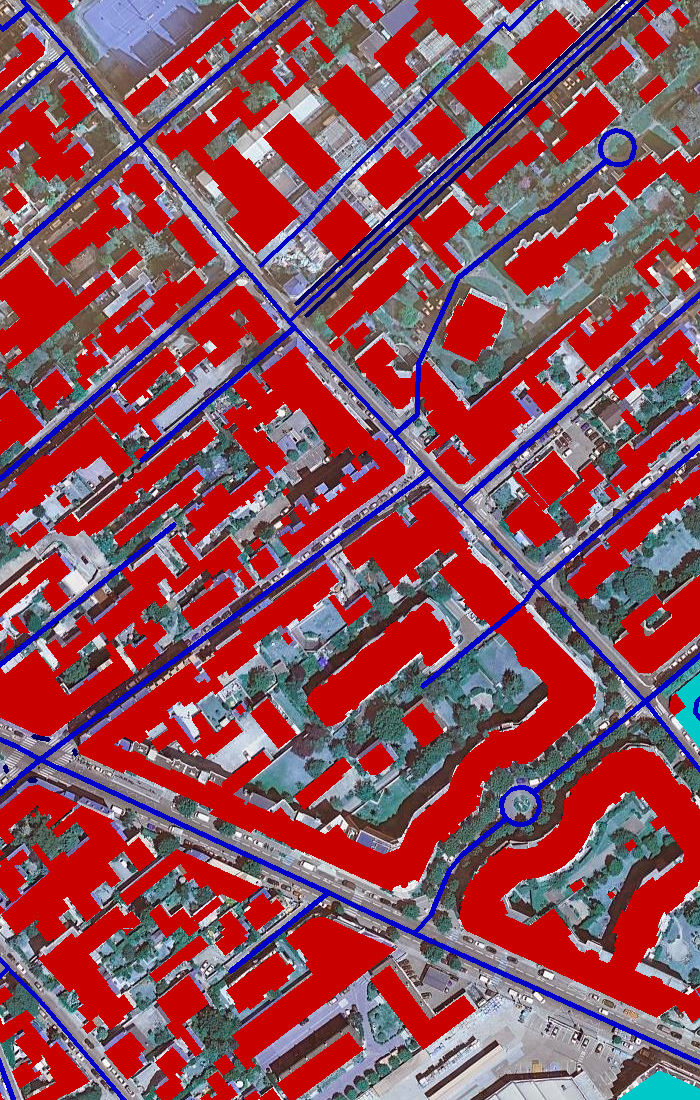

In [9]:
im = cv2.imread("data/t1/masks/paris.bmp")[:,:,::-1]
im = np.array(im)
# im = cv2.imdecode(im, 1)
mask = np.array([
    [50, 50], 
    [300, 300],
    [600,1000]
    ])
mask = mask.reshape((-1, 1, 2))
print(mask)
im = cv2.polylines(
    im, 
    mask, 
    isClosed=False,  
    color=(1,1,1),
    thickness=10
)

from PIL import Image
Image.fromarray(im[:1100,:700,::-1])